In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
import seaborn as sns
from PIL import Image
import matplotlib.patches as mpatches
# from pywaffle import Waffle

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
team = 'paris-saint-germain'

df = pd.read_csv(f'/code/assets/{team}/{team}_ptype.csv')
df2 = pd.read_csv(f'/code/assets/{team}/{team}_pass.csv')
df3 = pd.read_csv(f'/code/assets/{team}/{team}_attack.csv')
df3 = df3.rename(columns={'player':'Player'})

df = df.rename(columns={'player':'Player'})
df_pass = df2.merge(df, how='outer', on='Player')
df_pass = df_pass.merge(df3, how='outer', on='Player')

df_pass.columns

# convert()
# -L -> グレースケール
# -LA -> アルファ値を考慮したグレースケール
# HSV -> hue(色相) Saturation(彩度) Value(明度)
# point()
# - lambda x: x * 1.5 (1.5倍の明るさにする)
# - lambda x: x * 0.5 (0.5倍の明るさにする)

# セピア化
# - gray = img.convert('L')
# Image.merge('RGB',(
#                     gray.point(lambda x: x * 240/ 255),
#                     gray.point(lambda x: x * 200 / 255),
#                     gray.point(lambda x: x * 145 / 255)
# ))

# ガンマ変換
# - def gamma_table(gamma_r, gamma_g, gamma_b, gain_r=1.0, gain_g=1.0, gain_b=1.0):
#     r_tbl = [min(255, int((x / 255.) ** (1. / gamma_r) * gain_r * 255.)) for x in range(256)]
#     g_tbl = [min(255, int((x / 255.) ** (1. / gamma_g) * gain_g * 255.)) for x in range(256)]
#     b_tbl = [min(255, int((x / 255.) ** (1. / gamma_b) * gain_b * 255.)) for x in range(256)]
#     return r_tbl + g_tbl + b_tbl
# img.point(gamma_table(1.2, 0.5, 0.5))

# getbbox
# - 画像内で値が０でない最小領域を返す。値が全て０ならばNoneを返す
# alpha = Image.open("alpha.png")
# crop = alpha.split()[-1].getbbox()
# alpha.crop(crop)

# resize
# - img.resize((128, 128), Image.LANCZOS)

# 参考URL（https://qiita.com/pashango2/items/145d858eff3c505c100a）

img = Image.open(f'/code/assets/image/{team}.png').convert('L')
logo = img.copy()
logo.putalpha(70)

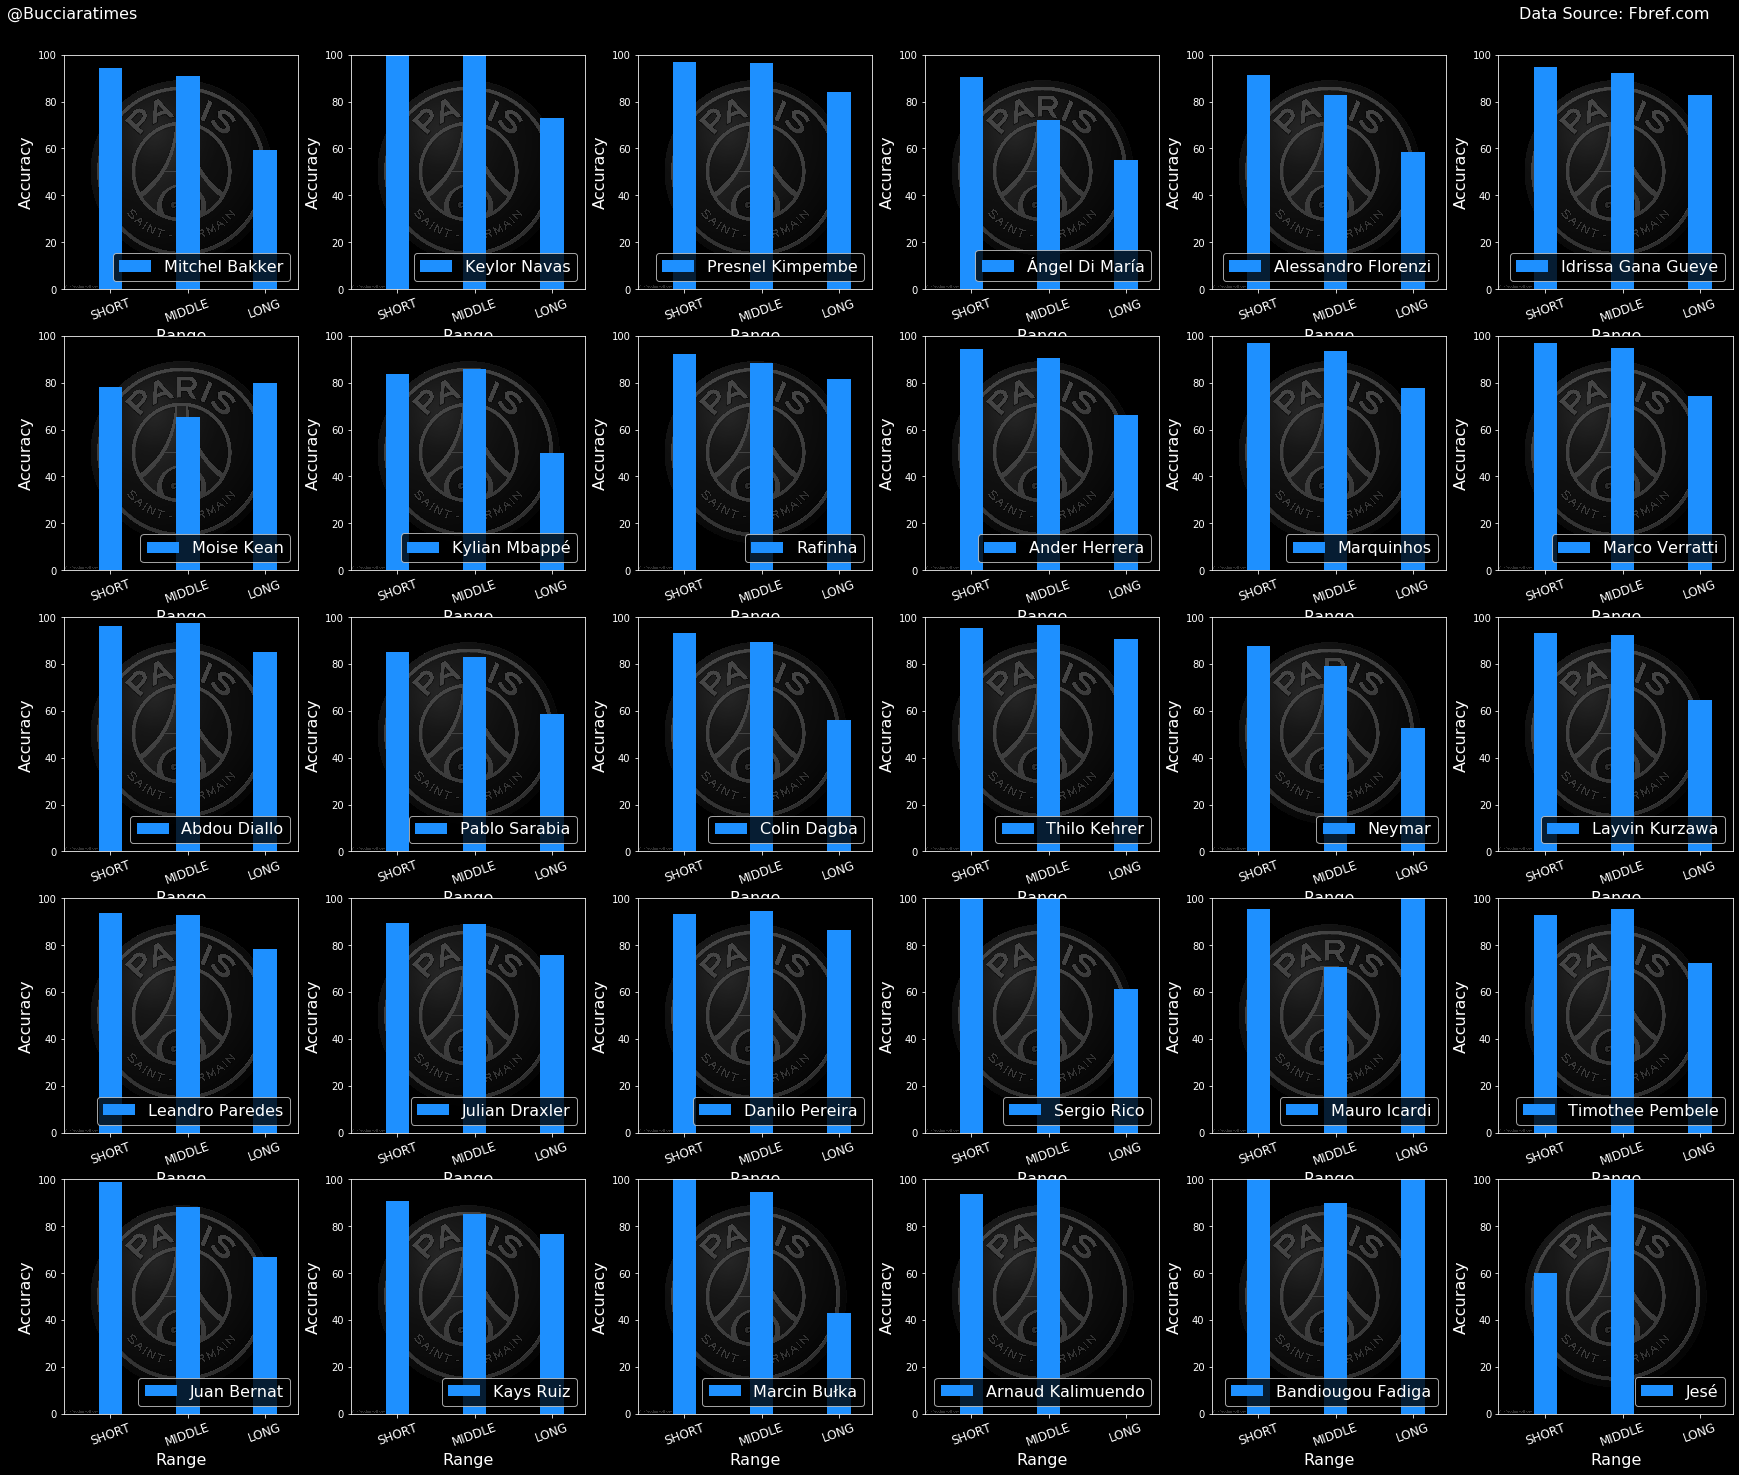

In [3]:
df_range = df_pass[['ShortPct', 'MediPct', 'LongPct']].T
df_range.rename(columns=df_pass['Player'])
plt.style.use('dark_background')
color = ['dodgerblue','tomato','lime','plum','green','gold','red','navy']

fig, axes = plt.subplots(ncols=6, nrows=5, figsize=(30,25))
row = 0
col = 0
X = range(20,100,33)
for i in range(30):
    axes[row,col].imshow(logo,extent=[0, 100, 0, 100])
    axes[row,col].set_ylim(0,100)
    axes[row,col].set_xlim(0,100)
    axes[row,col].bar(X,df_range.iloc[:,i], align="center", width=10,tick_label=['SHORT','MIDDLE','LONG'], color='dodgerblue',label=df_pass.iloc[i,0])
    axes[row,col].set_xlabel('Range',fontsize=16)
    axes[row,col].set_ylabel('Accuracy',fontsize=16)
    axes[row,col].legend(loc='lower right',fontsize=16)
    axes[row,col].set_xticklabels(['SHORT','MIDDLE','LONG'],rotation=20, fontsize=12)
    col += 1
    if col == 6:
        col = 0
        row += 1
    elif row == 5:
        break
plt.gcf().text(0.1,0.90,"@Bucciaratimes",fontsize=16)
plt.gcf().text(0.8,0.90,"Data Source: Fbref.com",fontsize=16)
plt.show()

fig.savefig(f'/code/output/{team}/range1227.png')

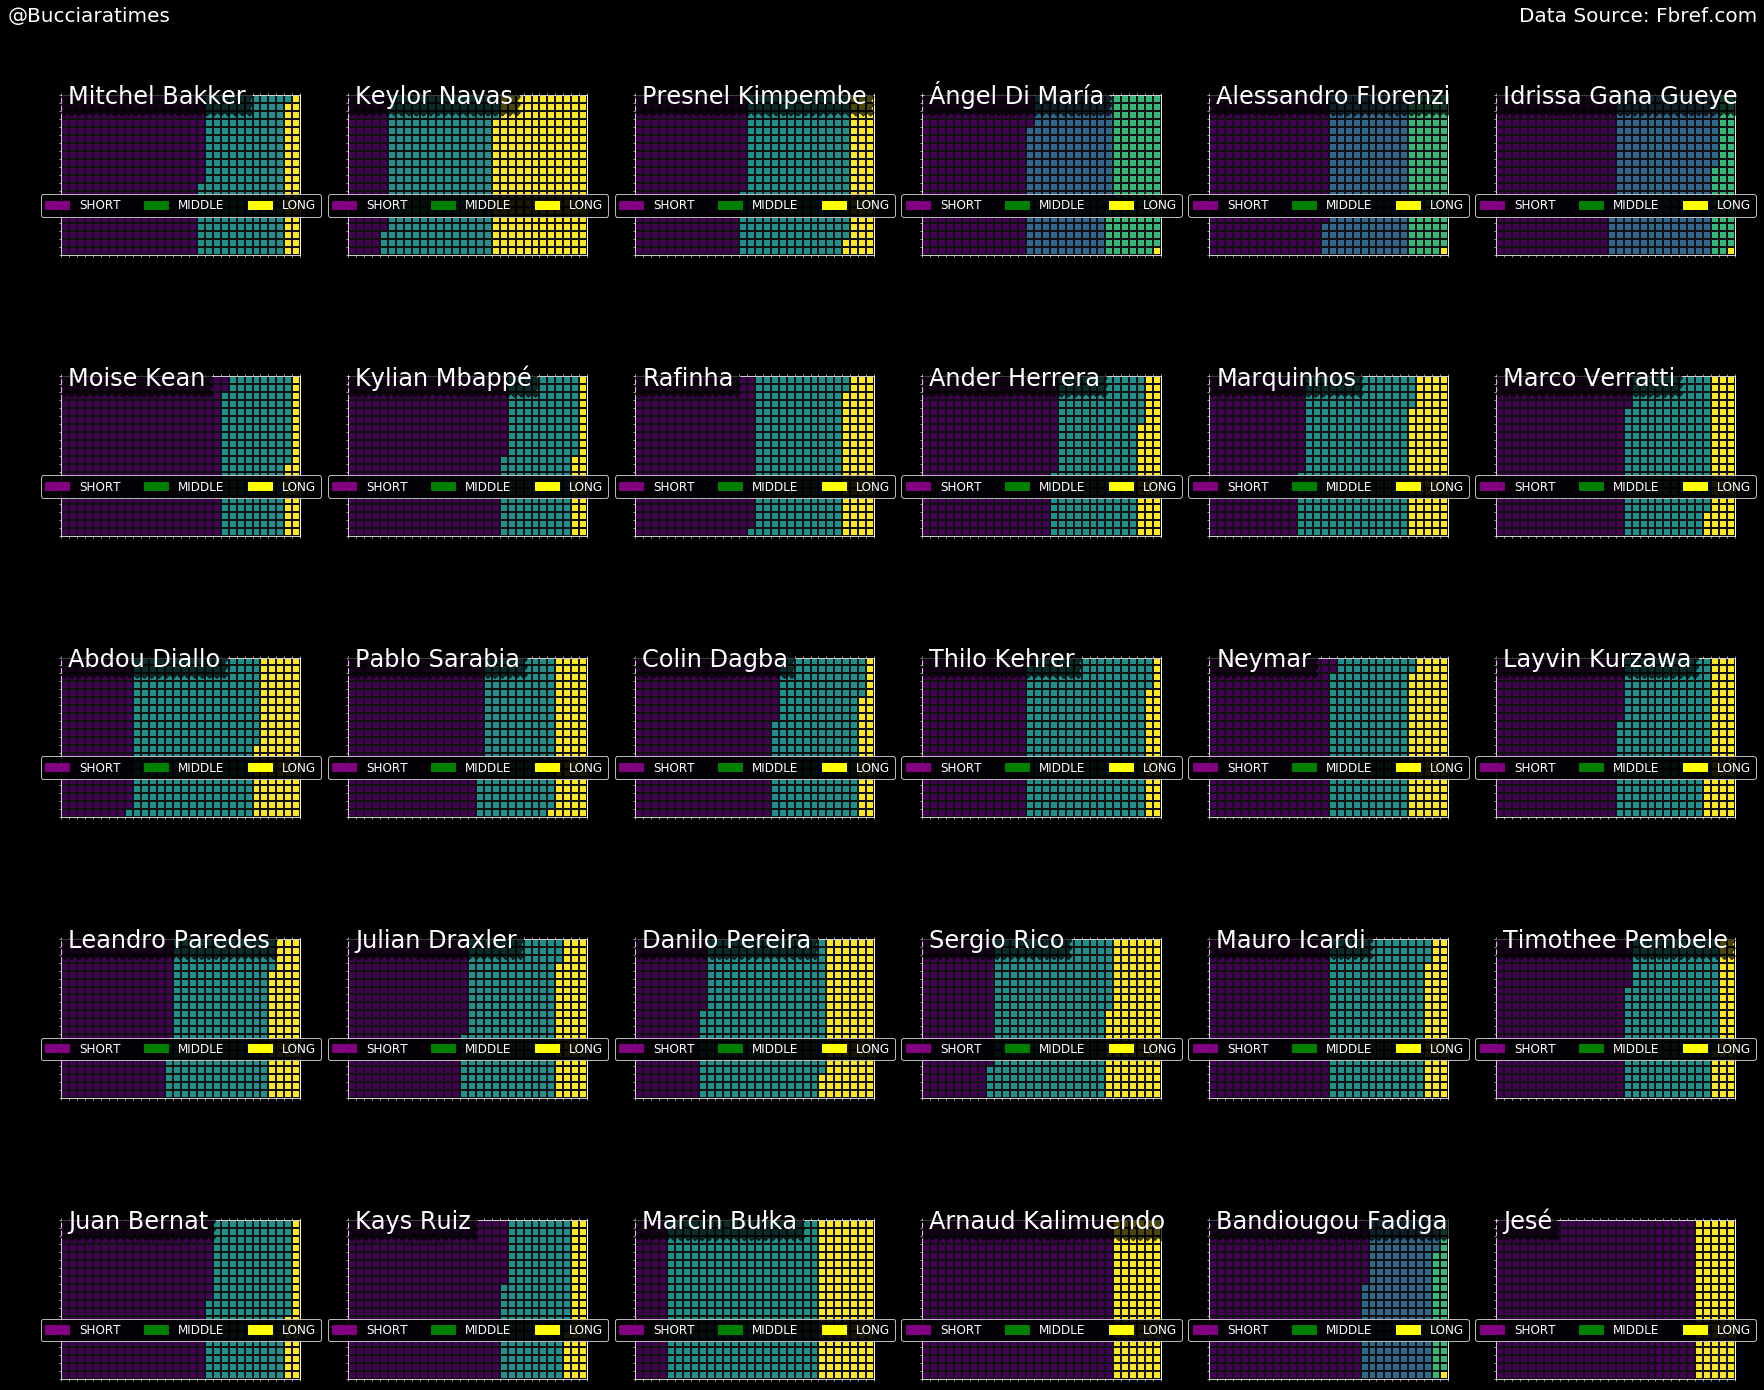

In [4]:
df_range2 = df_pass[['ShortPass','MediPass','LongPass']]
df_range2 = df_range2.T
df_range2 = df_range2.rename(columns=df_pass['Player'])


fig, axes = plt.subplots(ncols=6, nrows=5, figsize=(30,25))
colormap = plt.cm.viridis
colors = ['purple','green','yellow']

width = 30
height = 20
row = 0
col = 0
names = df_range2.columns.tolist()

for name in names:  
    total = df_range2[name].sum()
    proportions = [(value / total) for value in df_range2[name]]
    waffle_size = width * height
    each_tile_size = [round(proportion * waffle_size)for proportion in proportions]
    waffle = np.zeros((height, width))
    each_tile_index = 0
    tile_index = 0
    
#     縦方向にループさせたいからcolumns->rowでネスト
    for c in range(width):
        for r in range(height):
            tile_index += 1
#             tileの色の切り替えのコード
            if tile_index > sum(each_tile_size[0:each_tile_index]):
                each_tile_index += 1
            waffle[r,c] = each_tile_index
            
   
    axes[row,col].matshow(waffle, cmap=colormap, alpha=1)
    axes[row,col].set_xticks(np.arange(-0.5, (width), 1), minor=True)
    axes[row,col].set_yticks(np.arange(-0.5, (height), 1), minor=True)
    axes[row,col].grid(which='minor', color='#111111', linestyle='-', linewidth=2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])
    
    label_num = df_range2[name]
    label_name = ['SHORT', 'MIDDLE', 'LONG']
    value_sign = ''
    values_cumsum = np.cumsum(label_num)
    values = values_cumsum[len(values_cumsum) - 1]
    legend_handles = []
    for i, label in enumerate(label_name):
        if value_sign == '%':
            label_str = label + '(' + str(label_num[i]) + value_sign + ')'
        else:
            label_str = label
#             label_str = label + '(' + value_sign + str(label_num[i]) + ')'
        color_val = colormap(float(values_cumsum[i]) / values)
        legend_handles.append(mpatches.Patch(color=colors[i], label=label_str))
    
    axes[row,col].legend(
        handles=legend_handles,
        loc = 'lower center',
        ncol=len(label_name),
        bbox_to_anchor=(0.5, 0.2), # positioning of legend
        framealpha=0.9,
        fontsize=12
    )
    boxdic = {
    'color':'black',
    "boxstyle": "sawtooth",
    "linewidth" : 1,
    'alpha':0.7
    }
    axes[row,col].text(0.4, 0.6, name, size=24, bbox=boxdic)
    
    
    col += 1
    if col == 6:
        col = 0
        row += 1
    elif row == 5:
        break
        
#     fig, ax = plt.subplots(rows, cols, figsize=figsize)
#     for idx, r in enumerate(np.arange(-1, 1.1, 0.1)):
#         # 各plotのどこに配置するかを計算
#         row_i = idx//cols 
#         col_i = idx%cols
#         #相関係数に対してランダムな値を計算
#         x, y, actual_r = generate_values(r=r)
#         #生成したランダム値から実際の相関係数を表示
#         title = 'r={:.2f}'.format(actual_r)
#         ax[row_i, col_i].set_title(title)
#         ax[row_i, col_i].scatter(x, y, alpha=0.3, s=1)

    


plt.gcf().text(0.1,0.90,"@Bucciaratimes",fontsize=20)
plt.gcf().text(0.8,0.90,"Data Source: Fbref.com",fontsize=20)
plt.style.use('dark_background')
fig.savefig(f'/code/output/{team}/range_waffle.png')

    
